In [1]:
import psutil
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
from pystencils.session import *
from pystencils.boundaries import add_neumann_boundary, Neumann, Dirichlet, BoundaryHandling
from pystencils.slicing import slice_from_direction
import math
import time
%matplotlib inline

Test to see if pycuda is installed which is needed to run calculations on the GPU

In [2]:
try:
    import pycuda
    gpu = True
except ImportError:
    gpu = False
    pycuda = None
    print('No pycuda installed')
    
if pycuda:
    import pycuda.gpuarray as gpuarray

No pycuda installed


# Tutorial 03: Datahandling

This is a tutorial about the `DataHandling` class of pystencils. This class is an abstraction layer to
- link numpy arrays to pystencils fields
- handle CPU-GPU array transfer, such that one can write code that works on CPU and GPU
- makes it possible to write MPI parallel simulations to run on distributed-memory clusters using the waLBerla library

We will look at a small and easy example to demonstrate the usage of `DataHandling` objects. We will define an averaging kernel to every cell of an array, that writes the average of the neighbor cell values to the center.

## 1. Manual 

### 1.1. CPU kernels

In this first part, we set up a scenario manually without a `DataHandling`. In the next sections we then repeat the same setup with the help of the data handling. 

One concept of *pystencils* that may be confusing at first, is the differences between pystencils fields and numpy arrays. Fields are used to describe the computation *symbolically* with sympy, while numpy arrays hold the actual values where the computation is executed on. 

One option to create and execute a *pystencils* kernel is listed below. For reasons that become clear later we call this the **variable-field-size workflow**:

1. define pystencils fields
2. use sympy and the pystencils fields to define an update rule, that describes what should be done on *every cell* 
3. compile the update rule to a real function, that can be called from Python. For each field that was referenced in the symbolic description the function expects a numpy array, passed as named parameter
4. create some numpy arrays with actual data 
5. call the kernel - usually many times

Now, lets see how this actually looks in Python code:

In [3]:
# 1. field definitions
src_field, dst_field = ps.fields("src, dst:[2D]")

# 2. define update rule
update_rule = [ps.Assignment(lhs=dst_field[0, 0],
                             rhs=(src_field[1, 0] + src_field[-1, 0] + 
                                  src_field[0, 1] + src_field[0, -1]) / 4)]

# 3. compile update rule to function
kernel_function = ps.create_kernel(update_rule).compile()

# 4. create numpy arrays and call kernel
src_arr, dst_arr = np.random.rand(30, 30), np.zeros([30, 30])

# 5. call kernel
kernel_function(src=src_arr, dst=dst_arr)  # names of arguments have to match names passed to ps.fields()

This workflow separates the symbolic and the numeric stages very cleanly. The separation also makes it possible to stop after step 3, write the C-code to a file and call the kernel from a C program. Speaking of the C-Code - lets have a look at the generated sources:

In [4]:
ps.show_code(kernel_function.ast)

FUNC_PREFIX void kernel(double * RESTRICT _data_dst, double * RESTRICT const _data_src, int64_t const _size_dst_0, int64_t const _size_dst_1, int64_t const _stride_dst_0, int64_t const _stride_dst_1, int64_t const _stride_src_0, int64_t const _stride_src_1)
{
   for (int64_t ctr_0 = 1; ctr_0 < _size_dst_0 - 1; ctr_0 += 1)
   {
      double * RESTRICT _data_dst_00 = _data_dst + _stride_dst_0*ctr_0;
      double * RESTRICT _data_src_01 = _data_src + _stride_src_0*ctr_0 + _stride_src_0;
      double * RESTRICT _data_src_00 = _data_src + _stride_src_0*ctr_0;
      double * RESTRICT _data_src_0m1 = _data_src + _stride_src_0*ctr_0 - _stride_src_0;
      for (int64_t ctr_1 = 1; ctr_1 < _size_dst_1 - 1; ctr_1 += 1)
      {
         _data_dst_00[_stride_dst_1*ctr_1] = 0.25*_data_src_00[_stride_src_1*ctr_1 + _stride_src_1] + 0.25*_data_src_00[_stride_src_1*ctr_1 - _stride_src_1] + 0.25*_data_src_01[_stride_src_1*ctr_1] + 0.25*_data_src_0m1[_stride_src_1*ctr_1];
      }
   }
}

Even if it looks very ugly and low-level :) lets look at this code in a bit more detail. The code is generated in a way that it works for different array sizes. The size of the array is passed in the `_size_dst_` variables that specifiy the shape of the array for each dimension. Also, the memory layout (linearization) of the array can be different. That means the array could be stored in row-major or column-major order - if we pass in the array strides correctly the kernel does the right thing. If you're not familiar with the concept of strides check out [this stackoverflow post](https://stackoverflow.com/questions/53097952/how-to-understand-numpy-strides-for-layman) or search in the numpy documentation for strides - C vs Fortran order.

The goal of *pystencils* is to produce the fastest possible code. One technique to do this is to use all available information already on compile time and generate code that is highly adapted to the specific problem. In our case we already know the shape and strides of the arrays we want to apply the kernel to, so we can make use of this information. This idea leads to the **fixed-field-size workflow**. The main difference there is that we define the arrays first and therefore let *pystencils* know about the array shapes and strides, so that it can generate more specific code:

1. create numpy arrays that hold your data
2. define pystencils fields, this time telling pystencils already which arrays they correspond to, so that it knows about the size and strides

in the other steps nothing has changed

3. define the update rule 
4. compile update rule to kernel
5. run the kernel

In [5]:
# 1. create arrays first
src_arr, dst_arr = np.random.rand(30, 30), np.zeros([30, 30])

# 2. define symbolic fields - note the additional parameter that link an array to each field
src_field, dst_field = ps.fields("src, dst:[2D]", src=src_arr, dst=dst_arr)

# 3. define update rule
update_rule = [ps.Assignment(lhs=dst_field[0, 0],
                             rhs=(src_field[1, 0] + src_field[-1, 0] + 
                                  src_field[0, 1] + src_field[0, -1]) / 4)]

# 4. compile it
kernel_function = ps.create_kernel(update_rule).compile()

# 5. call kernel
kernel_function(src=src_arr, dst=dst_arr)  # names of arguments have to match names passed to ps.fields()

Functionally, both variants are equivalent. We see the difference only when we look at the generated code

In [6]:
ps.show_code(kernel_function.ast)

FUNC_PREFIX void kernel(double * RESTRICT _data_dst, double * RESTRICT const _data_src)
{
   for (int64_t ctr_0 = 1; ctr_0 < 29; ctr_0 += 1)
   {
      double * RESTRICT _data_dst_00 = _data_dst + 30*ctr_0;
      double * RESTRICT _data_src_01 = _data_src + 30*ctr_0 + 30;
      double * RESTRICT _data_src_00 = _data_src + 30*ctr_0;
      double * RESTRICT _data_src_0m1 = _data_src + 30*ctr_0 - 30;
      for (int64_t ctr_1 = 1; ctr_1 < 29; ctr_1 += 1)
      {
         _data_dst_00[ctr_1] = 0.25*_data_src_00[ctr_1 + 1] + 0.25*_data_src_00[ctr_1 - 1] + 0.25*_data_src_01[ctr_1] + 0.25*_data_src_0m1[ctr_1];
      }
   }
}

Compare this to the code above! It looks much simpler. The reason is that all index computations are already simplified since the exact field sizes and strides are known. This kernel now only works on arrays of the previously specified size. 

Lets try what happens if we use a different array:

In [7]:
src_arr2, dst_arr2 = np.random.rand(40, 40), np.zeros([40, 40])
try:
    kernel_function(src=src_arr2, dst=dst_arr2)
except ValueError as e:
    print(e)

Wrong shape of array dst. Expected (30, 30)


### 1.2. GPU simulations

Let's now jump to a seemingly unrelated topic: running kernels on the GPU. 
When creating the kernel, an additional parameter `target=ps.Target.GPU` has to be passed. Also, the compiled kernel cannot be called with numpy arrays directly, but has to be called with `pycuda.gpuarray`s instead. That means, we have to transfer our numpy array to GPU first. From this step we obtain a gpuarray, then we can run the kernel, hopefully multiple times so that the data transfer was worth the time. Finally we transfer the finished result back to CPU:

In [8]:
if pycuda:
    config = ps.CreateKernelConfig(target=ps.Target.GPU)
    kernel_function_gpu = ps.create_kernel(update_rule, config=config).compile()
    # transfer to GPU
    src_arr_gpu = pycuda.gpuarray.to_gpu(src_arr)
    dst_arr_gpu = pycuda.gpuarray.to_gpu(dst_arr)
    
    # run kernel on GPU, this is done many times in real setups
    kernel_function_gpu(src=src_arr_gpu, dst=dst_arr_gpu)
    
    # transfer result back to CPU
    dst_arr_gpu.get(dst_arr)

###  1.3. Summary: manual way

- Don't confuse *pystencils* fields and *numpy* arrays
    - fields are symbolic
    - arrays are numeric
- Use the fixed-field-size workflow whenever possible, since code might be faster. Create arrays first, then create fields from arrays
- if we run GPU kernels, arrays have to transferred to the GPU first

As demonstrated in the examples above we have to define 2 or 3 corresponding objects for each grid:

- symbolic pystencils field
- numpy array on CPU 
- for GPU run also a pycuda.gpuarray to mirror the data on the GPU

Managing these three objects manually is tedious and error-prone. We'll see in the next section how the data handling object takes care of this problem.

## 2. Introducing the data handling - serial version

### 2.1. Example for CPU simulations

The data handling internally keeps a mapping between symbolic fields and numpy arrays. When we create a field, automatically a corresponding array is allocated as well. Optionally we can also allocate memory on the GPU for the array as well. Lets dive right in and see how our example looks like, when implemented with a data handling.

In [9]:
dh = ps.create_data_handling(domain_size=(30, 30))

# fields are now created using the data handling
src_field = dh.add_array('src', values_per_cell=1)
dst_field = dh.add_array('dst', values_per_cell=1)

# kernel is created just like before
update_rule = [ps.Assignment(lhs=dst_field[0, 0],
                             rhs=(src_field[1, 0] + src_field[-1, 0] + src_field[0, 1] + src_field[0, -1]) / 4)]
kernel_function = ps.create_kernel(update_rule).compile()

# have a look at the generated code - it uses 
# the fast version where array sizes are compiled-in
#  ps.show_code(kernel_function.ast)

The data handling has methods to create fields - but where are the corresponding arrays? 
In the serial case you can access them as a member of the data handling, for example to initialize our 'src' array we can write

In [10]:
src_arr = dh.cpu_arrays['src']
src_arr.fill(0.0)

This method is nice and easy, but you should not use it if you want your simulation to run on distributed-memory clusters. We'll see why in the last section. So it is good habit to not access the arrays directly but use the data handling to do so. We can, for example, initialize the array also with the following code:

In [11]:
dh.fill('src', 0.0)

To run the kernels with the same code as before, we would also need the arrays. We could do that accessing the `cpu_arrays`:

In [12]:
kernel_function(src=dh.cpu_arrays['src'],
                dst=dh.cpu_arrays['dst'])

but to be prepared for MPI parallel simulations, again a method of the data handling should be used for this. 
Besides, this method is also simpler to use - since it automatically detects which arrays a kernel uses and passes them in.

In [13]:
dh.run_kernel(kernel_function)

To access the data read-only instead of using `cpu_arrays` the gather function should be used.
This function gives you a read-only copy of the domain or part of the domain. 
We will discuss this function later in more detail when we look at MPI parallel simulations.
For serial simulations keep in mind that modifying the resulting array does not change your original data!

In [14]:
read_only_copy = dh.gather_array('src', ps.make_slice[:, :], ghost_layers=False)

### 2.2. Example for GPU simulations

In this section we have a look at GPU simulations using the data handling. Only minimal changes are required.
When creating the data handling we can pass a 'default_target'. This means for every added field an array on the CPU and the GPU is allocated. This is a useful default, for more fine-grained control the `add_array` method also takes additional parameters controlling where the array should be allocated.

Additionally we also need to compile a GPU version of the kernel.

In [15]:
if gpu is False:
    dh = ps.create_data_handling(domain_size=(30, 30), default_target=ps.Target.CPU)
else:
    dh = ps.create_data_handling(domain_size=(30, 30), default_target=ps.Target.GPU)

# fields are now created using the data handling
src_field = dh.add_array('src', values_per_cell=1)
dst_field = dh.add_array('dst', values_per_cell=1)

# kernel is created just like before
update_rule = [ps.Assignment(lhs=dst_field[0, 0],
                             rhs=(src_field[1, 0] + src_field[-1, 0] + src_field[0, 1] + src_field[0, -1]) / 4)]
config = ps.CreateKernelConfig(target=dh.default_target)
kernel_function = ps.create_kernel(update_rule, config=config).compile()

dh.fill('src', 0.0)

The data handling provides function to transfer data between CPU and GPU

In [16]:
if gpu:
    dh.to_gpu('src')
    
dh.run_kernel(kernel_function)

if gpu:
    dh.to_cpu('dst')

usually one wants to transfer all fields that have been allocated on CPU and GPU at the same time:

In [17]:
dh.all_to_gpu()
dh.run_kernel(kernel_function)
dh.all_to_cpu()

We can always include the `all_to_*` functions in our code, since they do nothing if there are no arrays allocated on the GPU. Thus there is only a single point in the code where we can switch between CPU and GPU version: the `default_target` of the data handling. 

### 2.2 Ghost Layers and periodicity

The data handling can also provide periodic boundary conditions. Therefor the domain is extended by one layer of cells, the so-called ghost layer or halo layer.

In [18]:
print("Shape of domain         ", dh.shape)
print("Direct access to arrays ", dh.cpu_arrays['src'].shape)
print("Gather                  ", dh.gather_array('src', ghost_layers=True).shape)

Shape of domain          (30, 30)
Direct access to arrays  (32, 32)
Gather                   (32, 32)


 So the actual arrays are 2 cells larger than what you asked for. This additional layer is used to copy over the data from the other end of the array, such that for the stencil algorithm effectively the domain is periodic. This copying operation has to be started manually though:

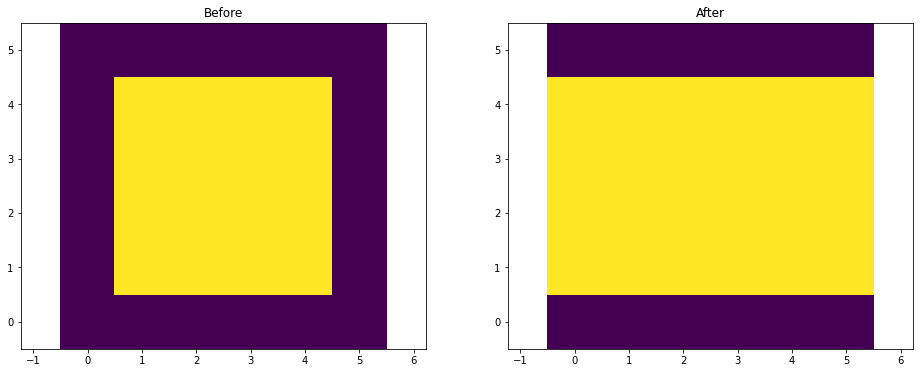

In [19]:
dh = ps.create_data_handling((4, 4), periodicity=(True, False))
dh.add_array("src")

# get copy function
copy_fct = dh.synchronization_function(['src'])

dh.fill('src', 0.0, ghost_layers=True)
dh.fill('src', 3.0, ghost_layers=False)
before_sync = dh.gather_array('src', ghost_layers=True).copy()

copy_fct() # copy over to get periodicity in x direction

after_sync = dh.gather_array('src', ghost_layers=True).copy()
plt.subplot(1,2,1)
plt.scalar_field(before_sync);
plt.title("Before")
plt.subplot(1,2,2)
plt.scalar_field(after_sync);
plt.title("After");

## 3. Going (MPI) parallel - the parallel data handling

### 3.1. Conceptual overview
To run MPI parallel simulations the waLBerla framework is used. waLBerla has to be compiled against your local MPI library and thus is a bit hard to install. We suggest to use the version shipped with conda for testing. For production, when you want to run on a cluster the best option is to build waLBerla yourself against the MPI library that is installed on your cluster.

Now lets have a look on how to write code that runs MPI parallel.
Since the data is distributed, we don't have access to the full array any more but only to the part that is stored locally. The domain is split into so called blocks, where one process might get one (or sometimes multiple) blocks. To do anything with the local part of the data we iterate over the **local** blocks to get the contents as numpy arrays. The blocks returned in the loop differ from process to process.

Copy the following snippet to a python file and run with multiple processes e.g.:
``mpirun -np 4 myscript.py`` you will see that there are as many blocks as processes.

In [20]:
dh = ps.create_data_handling(domain_size=(30, 30), parallel=True)
field = dh.add_array('field')
for block in dh.iterate():
    # offset is in global coordinates, where first inner cell has coordiante (0,0) 
    # and ghost layers have negative coordinates
    print(block.offset, block['field'].shape) 
    
    # use offset to create a local array 'my_data' for the part of the domain
    #np.copyto(block[field.name], my_data)

ValueError: Cannot create parallel data handling because walberla module is not available

To get some more interesting results here in the notebook we put multiple blocks onto our single notebook process. This makes not much sense for real simulations, but for testing and demonstration purposes this is useful.

In [ ]:
from waLBerla import createUniformBlockGrid
from pystencils.datahandling import ParallelDataHandling

blocks = createUniformBlockGrid(blocks=(2,1,2), cellsPerBlock=(20, 10, 20), 
                                oneBlockPerProcess=False, periodic=(1, 0, 0))
dh = ParallelDataHandling(blocks)
field = dh.add_array('field')
for block in dh.iterate():
    print(block.offset, block['field'].shape)

Now we see that we have four blocks with (20, 10, 20) block each, and the global domain is (40, 10, 40) big.
All subblock also have a ghost layer around them, which is used to synchronize with their neighboring blocks (over the network). For ghost layer synchronization the same `synchronization_function` is used that we used above for periodic boundaries, because copying between blocks and copying the ghost layer for periodicity uses the same mechanism.

In [ ]:
dh.gather_array('field').shape

### 3.2. Parallel example 

To illustrate this in more detail, lets run a simple kernel on a parallel domain. waLBerla can handle 3D domains only, so we choose a z-size of 1.

In [ ]:
blocks = createUniformBlockGrid(blocks=(2,4,1), cellsPerBlock=(20, 10, 1), 
                                oneBlockPerProcess=False, periodic=(1, 1, 0))
dh = ParallelDataHandling(blocks, dim=2)
src_field = dh.add_array('src')
dst_field = dh.add_array('dst')

update_rule = [ps.Assignment(lhs=dst_field[0, 0 ],
                             rhs=(src_field[1, 0] + src_field[-1, 0] + 
                                  src_field[0, 1] + src_field[0, -1]) / 4)]

# 3. compile update rule to function
kernel_function = ps.create_kernel(update_rule).compile()

Now lets initialize the arrays. To do this we can get arrays (meshgrids) from the block with the coordinates of the local cells. We use this to initialize a circular shape.

In [ ]:
dh.fill('src', 0.0)
for block in dh.iterate(ghost_layers=False, inner_ghost_layers=False):
    x, y = block.midpoint_arrays
    inside_sphere = (x -20)**2 + (y-25)**2  < 8 ** 2
    block['src'][inside_sphere] = 1.0
plt.scalar_field( dh.gather_array('src') );

Now we can run our compute kernel on this data as usual. We just have to make sure that the field is synchronized after every step, i.e. that the ghost layers are correctly updated.

In [ ]:
sync = dh.synchronization_function(['src'])
for i in range(40):
    sync()
    dh.run_kernel(kernel_function)
    dh.swap('src', 'dst')

In [ ]:
plt.scalar_field( dh.gather_array('src') );